## Criação lookup

In [23]:
import json
import pandas as pd
import os

# Carregamento dos Dados de Tráfego
print("Carregando dados de tráfego...")
df_trafego = pd.read_csv("../data/honeypot_data.csv")

# Criar diretório se não existir
os.makedirs("../data/graph", exist_ok=True)

# Gerar lookup para IPs únicos
unique_ips = pd.concat([df_trafego['src_ip'], df_trafego['dst_ip']]).unique()
ip_lookup = {str(ip): idx for idx, ip in enumerate(unique_ips)}

# Salvar os dicionários como JSON
with open("../data/graph/ip_lookup.json", "w") as file:
    json.dump(ip_lookup, file, indent=4)

print("Arquivo ip_lookup.json criado com sucesso!")


Carregando dados de tráfego...
Arquivo ip_lookup.json criado com sucesso!


## Features

In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
from glob import glob

# Adiciona caminho para importações se necessário
import sys
sys.path.append('../')

from src.preprocessing import *
from src.preprocessing.nlp import *

# Caminhos e parâmetros
FILTER = 5
FEATURES_DIR = "../data/features/"
GRAPH_DIR = "../data/graph/"
TRAFFIC_FILE = "../data/honeypot_data.csv"
GT_FILE = "../data/ground_truth_simulado.csv"
MATRIZ_DIR = "../data/matrizes/"

os.makedirs(FEATURES_DIR, exist_ok=True)

# Carregar dados
print("Carregando dados de tráfego...")
df_trafego = pd.read_csv(TRAFFIC_FILE)
df_trafego.rename(columns={'dst_ip': 'destino', 'pacotes': 'pkts'}, inplace=True)
df_trafego = apply_packets_filter(df_trafego, FILTER)

print("Carregando dados de Ground Truth...")
gt = pd.read_csv(GT_FILE)

print("Carregando matrizes de adjacência...")
graph_files = sorted(glob(f"{MATRIZ_DIR}/matriz_adjacencia_dia_*.txt"))
if not graph_files:
    raise FileNotFoundError(f"Nenhuma matriz encontrada em {MATRIZ_DIR}")

print("Carregando dicionários de lookup...")
with open(f"{GRAPH_DIR}/ip_lookup.json", "r") as file:
    ip_lookup = json.load(file)

# Processar por dia
for file in tqdm(graph_files, desc="Processando features por dia"):
    dia = os.path.basename(file).split("_")[-1].split(".")[0]
    print(f"\n Processando dia {dia}...")

    try:
        df_grafo = pd.read_csv(file, delim_whitespace=True, names=["origem", "destino", "peso"])
    except pd.errors.ParserError as e:
        print(f"Erro ao processar {file}: {e}")
        continue

    df_trafego_dia = df_trafego[df_trafego['interval'] == int(dia)]
    if df_trafego_dia.empty:
        print(f" Nenhum dado para o dia {dia}.")
        continue

    df_merged = df_trafego_dia.merge(gt, on='src_ip', how='left').dropna()

    # Adicionar IDs
    df_merged['origem_id'] = df_merged['src_ip'].map(ip_lookup).fillna(-1).astype(int)


    #  Geração de features baseadas em traços de personalidade
    def extrair_features_por_nos(df, id_col):
        return df.groupby(id_col).agg({
            'tempo_ocioso': 'mean',          # Paciência          # Emocionalidade
            'rastros': 'mean', 
            'etapas': 'mean', 
            'mov_mouse': 'mean', 
            'repet_comando': 'mean', 
            'pulos': 'mean',    # Perfeccionismo
            'pkts': ['mean', 'sum']          # Pacotes como métrica complementar
        }).reset_index()

    # Features por origem e destino
    feat_origem = extrair_features_por_nos(df_merged, 'origem_id')

    # Renomear colunas
    feat_origem.columns = ['node_id'] + [f"{col}_origem" for col in feat_origem.columns[1:]]

    # Combinar e preencher
    features = feat_origem

    # Garantir que todos os IPs estejam presentes
    todos_nos = pd.DataFrame({'node_id': list(ip_lookup.values())})
    features = todos_nos.merge(features, on='node_id', how='left').fillna(0)

    # Salvar
    feature_file = f"{FEATURES_DIR}/features_{dia}.csv"
    features.to_csv(feature_file, index=False)
    print(f" Features do dia {dia} salvas em '{feature_file}'.")

print("\n Extração e salvamento de features concluídos!")


Carregando dados de tráfego...
Carregando dados de Ground Truth...
Carregando matrizes de adjacência...
Carregando dicionários de lookup...


Processando features por dia:   0%|          | 0/3 [00:00<?, ?it/s]


 Processando dia 01...
 Features do dia 01 salvas em '../data/features//features_01.csv'.

 Processando dia 02...
 Features do dia 02 salvas em '../data/features//features_02.csv'.

 Processando dia 03...
 Features do dia 03 salvas em '../data/features//features_03.csv'.

 Extração e salvamento de features concluídos!


## Embeddings

In [25]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import json
import os
from tqdm.notebook import tqdm_notebook as tqdm
from glob import glob
import numpy as np
from src.preprocessing.gnn import generate_adjacency_matrices

# Parâmetros
epochs = 50
DATASET_DIR = '../data'
GRAPH_DIR = f'{DATASET_DIR}/graph'
OUTPUT_DIR = f'{DATASET_DIR}/auto_embeddings'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Carregar lookup de IPs
ip_lookup_path = f'{GRAPH_DIR}/ip_lookup.json'
if not os.path.exists(ip_lookup_path):
    raise FileNotFoundError(f"Arquivo de mapeamento de IPs não encontrado: {ip_lookup_path}")

with open(ip_lookup_path, 'r') as file:
    ip_lookup = json.load(file)
    reverse_lookup = {v: k for k, v in ip_lookup.items()}
    ip_nodes = len(reverse_lookup)

# Carregar features
flist = sorted(glob(f'{DATASET_DIR}/features/*.csv'))
features = []
for file in tqdm(flist, desc='Loading features'):
    feat = pd.read_csv(file, index_col=[0]).sort_index()
    features.append(torch.tensor(feat.to_numpy(), dtype=torch.float32))

# Carregar matrizes de adjacência
flist = sorted(glob(f'{DATASET_DIR}/matrizes/*.txt'))
adj_matrices = generate_adjacency_matrices(flist, ip_lookup, weighted=True)

# Modelo de Autoencoder com GCN
class GCN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 2 * out_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(2 * out_features, out_features)

    def forward(self, x, adj):
        h = torch.matmul(adj, x)
        h = self.fc1(h)
        h = self.relu(h)
        h = self.fc2(h)
        return h

class GCN_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = GCN(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, adj):
        z = self.encoder(x, adj)
        x_hat = self.decoder(z)
        return x_hat, z

# Treinamento incremental com autoencoder
pbar = tqdm(total=len(adj_matrices) * epochs)

import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

for i in range(len(adj_matrices)):
    A = torch.tensor(adj_matrices[i], dtype=torch.float32)
    X = features[i]

    input_dim = X.shape[1]
    hidden_dim = 128
    model = GCN_Autoencoder(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        x_hat, _ = model(X, A)
        loss = loss_fn(x_hat, X)
        loss.backward()
        optimizer.step()
        pbar.update(1)

    # Obter os embeddings
    model.eval()
    with torch.no_grad():
        _, embeddings = model(X, A)

    embeddings = embeddings[:ip_nodes]
    new_index = [reverse_lookup[x] for x in range(ip_nodes)]
    embeddings_df = pd.DataFrame(embeddings.numpy(), index=new_index)
    embeddings_df.index.name = "src_ip"

    day = f'{i+1:02d}'
    embeddings_df.to_csv(f'{OUTPUT_DIR}/embeddings_autoencoder_day_{day}.csv')

    torch.save(model.state_dict(), f'../data/graph/modelo_gcn_day_{day}.pth')
    torch.save(A, f'../data/matrizes/adj_matrix_day_{day}.pt')
    torch.save(X, f'{OUTPUT_DIR}/X_train_day_{day}.pt')


Loading features:   0%|          | 0/3 [00:00<?, ?it/s]

Carregando ../data/matrizes/matriz_adjacencia_dia_01.txt...
../data/matrizes/matriz_adjacencia_dia_01.txt - Dados convertidos para IDs numéricos:
   src  dst  weight
0    5   13     150
1    5    8      88
2    5   17      55
3    5    0     192
4    1    5     223
Carregando ../data/matrizes/matriz_adjacencia_dia_02.txt...
../data/matrizes/matriz_adjacencia_dia_02.txt - Dados convertidos para IDs numéricos:
   src  dst  weight
0    5    6     162
1    5   16     163
2    1    6     118
3    1   17     157
4    1   11     154
Carregando ../data/matrizes/matriz_adjacencia_dia_03.txt...
../data/matrizes/matriz_adjacencia_dia_03.txt - Dados convertidos para IDs numéricos:
   src  dst  weight
0    5    1      60
1    5    9     156
2    1    2      27
3   10    8      37
4   10   14     130


  0%|          | 0/150 [00:00<?, ?it/s]

## Clusters formados

Clusters encontrados: [0 1 2 3]


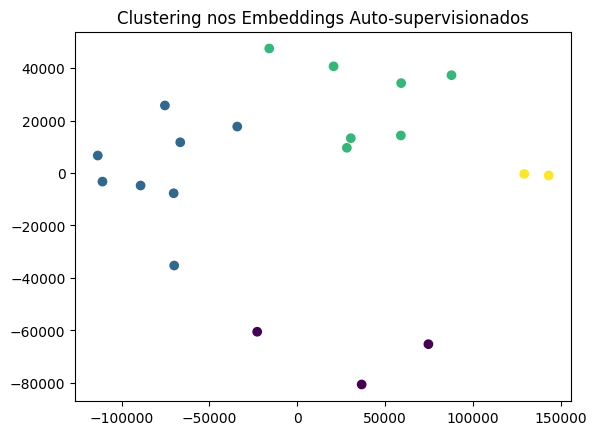

In [26]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler

# Agrupamento
kmeans = KMeans(n_clusters=4, random_state=42)  # Número de clusters pode ser estimado
clusters = kmeans.fit_predict(embeddings.numpy())
print("Clusters encontrados:", np.unique(clusters))

joblib.dump(kmeans, '../data/cluster/modelo_kmeans.pkl')

# Visualização
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings.numpy())

plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='viridis')
plt.title("Clustering nos Embeddings Auto-supervisionados")
plt.show()
